In [60]:
import sys
sys.path.append('../../../')

In [61]:
from win10toast import ToastNotifier
toast = ToastNotifier()

In [62]:
import torch
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
import numpy as np
from tqdm.auto import tqdm, trange

from models.train_reg import train, test
from models.models import GCN, GAT, GraphSAGE, FNN
from models.utils import ContagionDataset, set_seed
from sklearn.metrics import matthews_corrcoef, mean_squared_error, mean_absolute_error

In [63]:
def pretty(ld, indent=0):
    with open('result.txt', 'w', encoding='utf-8') as file:
        for d in tqdm(ld):
            file.write('{' + '\n')
            for key, value in d.items():
                file.write('\t' * (indent+1) + str(key) + ':' + str(value) + '\n')
                # file.write('\t' * (indent+1) + str(key) + '\n')
                # file.write('\t' * (indent+2) + str(value) + '\n')
            file.write('},\n')

In [64]:
do_train = False

seed = 4444
set_seed(seed)

metric_filter_1 = 'val_rmse_perc'
metric_filter_2 = 'test_rmse_perc'

data_dir = '../data'
log_path = './logs'
save_path = './saved'

# Big dataset: Additional stress

In [65]:
sets_lengths = (0.07, 0.03, 0.9)
target = 'additional_stress'

dataset = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    target = target,
)

out_feats = 1

## Baseline

### FNN

In [66]:
save_model = f'{save_path}_fnn'
log_dir = f'{log_path}_fnn'

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = False,
    target = target,
)

# fnn_model = dict(
#     in_features=[len(dataset_val.node_attributes)],
#     h_features=[[5, 10], [10, 15], [5,5,5], [5, 10, 15], [5, 10, 15, 20], [5], [10], [15]],
#     out_features=[dataset_val.num_classes],
#     activation=[torch.nn.ReLU()],
#     norm_nodes = [None, 'bn', 'gn'],
#     dropout=[0.2, 0.5, 0.0],
#     # other
#     lr=[1, 1e-1, 1e-2],
#     label_smoothing=[0.0, 0.2, 0.4],
# )

fnn_model = dict(
    in_features=[len(dataset_val.node_attributes)],
    h_features=[[10, 15], [10, 15, 20], [5, 10, 15], [len(dataset_val.node_attributes)] * 2],
    out_features=[dataset_val.num_classes],
    activation=[torch.nn.ReLU()],
    norm_nodes = [None, 'bn', 'gn'],
    dropout=[0.2, 0.0],
    # other
    lr=[1e-1],
)
list_model = [dict(zip(fnn_model.keys(), k)) for k in itertools.product(*fnn_model.values())]

In [67]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')

        train(
            model=FNN(**d),
            dict_model=d,
            dataset_train=dataset_val,
            dataset_val=dataset_val,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=False,
            loss_type='mse',
        )

#### Results

In [68]:
res_edges_fnn = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=False,
)

100%|██████████| 264/264 [00:16<00:00, 15.70it/s]


In [69]:
res_edges = res_edges_fnn
res_edges[0]

{'in_features': 4,
 'h_features': [4, 4],
 'out_features': 4,
 'activation': ReLU(),
 'norm_nodes': 'bn',
 'dropout': 0.0,
 'train_lr': 0.1,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': False,
 'train_loss_type': 'mse',
 'train_self_loop': False,
 'train_drop_edges': 0,
 'train_loss': 0.68998843,
 'train_acc': 0.45714282989501953,
 'val_acc': 0.5111109614372253,
 'epoch': 70,
 'model_class': 'fnn',
 'path_name': '4_[4_4]_4_ReLU()_bn_0.0_0.1_adamw_max_val_mcc_False_mse_False_0_70',
 'train_rmse': 1.0,
 'val_rmse': 1.0327955589886444,
 'test_rmse': 0.9820613241770824,
 'train_rmse_perc': 0.2330398,
 'val_rmse_perc': 0.21886963,
 'test_rmse_perc': 0.22998434,
 'train_mcc': 0.3212848290170763,
 'val_mcc': 0.3375210905132851,
 'test_mcc': 0.346929530824148,
 'test_acc': 0.49703702330589294,
 'train_mae_perc': 0.18721515,
 'val_mae_perc': 0.16009821,
 'test_mae_perc': 0.17830658}

In [70]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [4, 4],
 'out_features': 4,
 'activation': ReLU(),
 'norm_nodes': 'bn',
 'dropout': 0.0,
 'train_lr': 0.1,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': False,
 'train_loss_type': 'mse',
 'train_self_loop': False,
 'train_drop_edges': 0,
 'train_loss': 0.6896431,
 'train_acc': 0.40952378511428833,
 'val_acc': 0.5111109614372253,
 'epoch': 100,
 'model_class': 'fnn',
 'path_name': '4_[4_4]_4_ReLU()_bn_0.0_0.1_adamw_max_val_mcc_False_mse_False_0_100',
 'train_rmse': 0.8890872794479687,
 'val_rmse': 0.8299933065325822,
 'test_rmse': 0.8886110676947647,
 'train_rmse_perc': 0.2099247,
 'val_rmse_perc': 0.1842766,
 'test_rmse_perc': 0.2118893,
 'train_mcc': 0.2916860347514282,
 'val_mcc': 0.30948846732650864,
 'test_mcc': 0.3180037698860737,
 'test_acc': 0.4674074053764343,
 'train_mae_perc': 0.17871618,
 'val_mae_perc': 0.1398352,
 'test_mae_perc': 0.17054571}

In [71]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [4, 4],
 'out_features': 4,
 'activation': ReLU(),
 'norm_nodes': 'bn',
 'dropout': 0.0,
 'train_lr': 0.1,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': False,
 'train_loss_type': 'mse',
 'train_self_loop': False,
 'train_drop_edges': 0,
 'train_loss': 0.68965405,
 'train_acc': 0.4285714030265808,
 'val_acc': 0.5555554032325745,
 'epoch': 90,
 'model_class': 'fnn',
 'path_name': '4_[4_4]_4_ReLU()_bn_0.0_0.1_adamw_max_val_mcc_False_mse_False_0_90',
 'train_rmse': 0.8783100656536799,
 'val_rmse': 0.8027729719194864,
 'test_rmse': 0.8835953489809353,
 'train_rmse_perc': 0.21045294,
 'val_rmse_perc': 0.18505773,
 'test_rmse_perc': 0.21136814,
 'train_mcc': 0.31265908561802713,
 'val_mcc': 0.3748645235484605,
 'test_mcc': 0.33230735108458737,
 'test_acc': 0.47999998927116394,
 'train_mae_perc': 0.17903008,
 'val_mae_perc': 0.13981655,
 'test_mae_perc': 0.1698353}

In [72]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 264/264 [00:00<00:00, 6623.54it/s]


In [73]:
cm = all[sort_idx[0]]['test_cm'][0]

In [74]:
(cm.labels==0).sum()

tensor(335)

<module 'matplotlib.pyplot' from 'c:\\Users\\vibal\\PycharmProjects\\systemic-risk-predictor\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

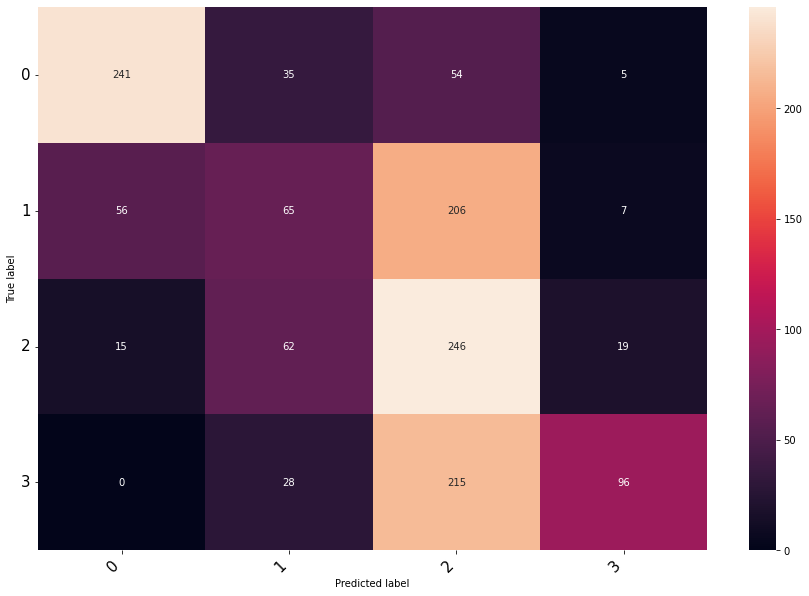

In [75]:
cm.visualize()

In [76]:
cm.class_accuracy

tensor([0.7194, 0.1946, 0.7193, 0.2832])

In [77]:
[mean_squared_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k], squared=False) for k in range(0, cm.size)]

[0.21177538, 0.23151252, 0.15888196, 0.23520467]

In [78]:
[mean_absolute_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k]) for k in range(0, cm.size)]

[0.14198716, 0.20743911, 0.11963656, 0.21094869]

### GCN

In [79]:
save_model = f'{save_path}_gcn'
log_dir = f'{log_path}_gcn'

add_self_loop = True

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = add_self_loop,
    target = target,
)

gcn_model = dict(
    in_features=[len(dataset_val.node_attributes)],
    h_features=[[15] * 3, [10, 15, 20], [5, 10, 15, 20],],
    out_features=[dataset_val.num_classes],
    activation=[torch.nn.ReLU()],
    norm_edges=['both', 'none'],
    norm_nodes=[None, 'bn', 'gn'],
    dropout=[0.2, 0.0],
    # other
    lr=[1e-1],
    use_edge_weight=[True,],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(gcn_model.keys(), k)) for k in itertools.product(*gcn_model.values())]

# gcn_model = dict(
#     in_features=[len(dataset_val.node_attributes)],
#     h_features=[[10] * 3],
#     out_features=[dataset_val.num_classes],
#     activation=[torch.nn.ReLU()],
#     norm_edges=['both', 'none'],
#     norm_nodes=[None, 'bn', 'gn'],
#     dropout=[0.2, 0.0],
#     # other
#     lr=[1],
#     label_smoothing=[0.0,],
#     use_edge_weight=[True, ],
#     drop_edges=[0,0.2],
# )
# list_model = [{i:j[k] for i,j in gcn_model.items()} for k in range(len(gcn_model['in_features']))]

In [80]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        # dataset_valid = ContagionDataset(
        #     raw_dir=data_dir,
        #     drop_edges=0,
        #     sets_lengths=sets_lengths,
        #     add_self_loop = add_self_loop,
        #     target = target,
        #     seed=seed,
        # )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GCN(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_val,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=use_edge_weight,
            loss_type='mse',
        )

#### Results

In [81]:
res_edges_gcn = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=True,
)

100%|██████████| 792/792 [00:44<00:00, 17.65it/s]


In [82]:
res_edges = res_edges_gcn
res_edges[0]

{'in_features': 4,
 'h_features': [10, 15, 20],
 'out_features': 4,
 'activation': ReLU(),
 'norm_edges': 'none',
 'norm_nodes': 'bn',
 'dropout': 0.2,
 'train_lr': 0.1,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'train_loss': 1.0065331,
 'train_acc': 0.3333333134651184,
 'val_acc': 0.5999998450279236,
 'epoch': 30,
 'model_class': 'gcn',
 'path_name': '4_[10_15_20]_4_ReLU()_none_bn_0.2_0.1_adamw_max_val_mcc_True_mse_True_0.2_30',
 'train_rmse': 0.9710083124552245,
 'val_rmse': 0.816496580927726,
 'test_rmse': 0.9083970415986531,
 'train_rmse_perc': 0.255544,
 'val_rmse_perc': 0.19798984,
 'test_rmse_perc': 0.2315902,
 'train_mcc': 0.23012839368940052,
 'val_mcc': 0.458386596181596,
 'test_mcc': 0.32734846506170345,
 'test_acc': 0.4385185241699219,
 'train_mae_perc': 0.21409862,
 'val_mae_perc': 0.1565142,
 'test_mae_perc': 0.18640251}

In [83]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [5, 10, 15, 20],
 'out_features': 4,
 'activation': ReLU(),
 'norm_edges': 'none',
 'norm_nodes': 'gn',
 'dropout': 0.2,
 'train_lr': 0.1,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 0.85373163,
 'train_acc': 0.34285712242126465,
 'val_acc': 0.577777624130249,
 'epoch': 20,
 'model_class': 'gcn',
 'path_name': '4_[5_10_15_20]_4_ReLU()_none_gn_0.2_0.1_adamw_max_val_mcc_True_mse_True_0_20',
 'train_rmse': 0.9411239481143202,
 'val_rmse': 0.7888106377466155,
 'test_rmse': 0.8973211159808874,
 'train_rmse_perc': 0.23672453,
 'val_rmse_perc': 0.19294201,
 'test_rmse_perc': 0.22518797,
 'train_mcc': 0.2516616437826872,
 'val_mcc': 0.4190241448003311,
 'test_mcc': 0.3030229996146937,
 'test_acc': 0.42444443702697754,
 'train_mae_perc': 0.1977515,
 'val_mae_perc': 0.15076531,
 'test_mae_perc': 0.18471587}

In [84]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [5, 10, 15, 20],
 'out_features': 4,
 'activation': ReLU(),
 'norm_edges': 'none',
 'norm_nodes': 'gn',
 'dropout': 0.2,
 'train_lr': 0.1,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 0.8650112,
 'train_acc': 0.3809523582458496,
 'val_acc': 0.5555554032325745,
 'epoch': 90,
 'model_class': 'gcn',
 'path_name': '4_[5_10_15_20]_4_ReLU()_none_gn_0.2_0.1_adamw_max_val_mcc_True_mse_True_0_90',
 'train_rmse': 0.9050124966251124,
 'val_rmse': 0.8027729719194864,
 'test_rmse': 0.8593710016742003,
 'train_rmse_perc': 0.23138,
 'val_rmse_perc': 0.20016591,
 'test_rmse_perc': 0.21701716,
 'train_mcc': 0.30833969954448665,
 'val_mcc': 0.38184857209494616,
 'test_mcc': 0.32633356317290424,
 'test_acc': 0.4385185241699219,
 'train_mae_perc': 0.19901712,
 'val_mae_perc': 0.16090982,
 'test_mae_perc': 0.18166964}

In [85]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 792/792 [00:00<00:00, 11344.71it/s]


### GraphSAGE

In [86]:
save_model = f'{save_path}_sage'
log_dir = f'{log_path}_sage'

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = True,
    target = target,
)

sage_model = dict(
    in_features = [len(dataset.node_attributes)],
    h_features = [[15] * 3, [20], [15], [20] * 2, [15] * 2, [25], [30]], 
    out_features = [out_feats],
    aggregator_type = ['lstm'],
    norm_edges = ['right', 'none'],
    norm_nodes = [None, 'bn', 'gn'],
    activation = [torch.nn.ReLU()],
    feat_drop = [0.2, 0],
    # other
    lr=[1e-2],
    use_edge_weight=[True],
    add_self_loop=[True],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(sage_model.keys(), k)) for k in itertools.product(*sage_model.values())]

# sage_model = dict(
#     in_features = [len(dataset.node_attributes)],
#     h_features = [[30] * 3], 
#     out_features = [out_feats],
#     aggregator_type = ['lstm'],
#     norm_edges = ['none'],
#     norm_nodes = ['gn'],
#     activation = [torch.nn.ReLU()],
#     feat_drop = [0],
#     # other
#     lr=[1e-2],
#     label_smoothing=[0.0],
#     use_edge_weight=[True],
#     add_self_loop=[True],
#     drop_edges=[0],
# )
# list_model = [{i:j[k] for i,j in sage_model.items()} for k in range(len(sage_model['in_features']))]

In [87]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        add_self_loop = d.pop('add_self_loop')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        dataset_valid = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=0,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GraphSAGE(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_valid,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=use_edge_weight,
            loss_type='mse',
        )

#### Results

In [88]:
res_edges_sage = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=True,
)

toast.show_toast("Done")

100%|██████████| 1386/1386 [06:55<00:00,  3.34it/s]


True

In [89]:
res_edges = res_edges_sage
res_edges[0]

{'in_features': 4,
 'h_features': [20, 20],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'feat_drop': 0.2,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 0.38083753,
 'train_acc': 0.714285671710968,
 'val_acc': 0.6444442868232727,
 'epoch': 90,
 'model_class': 'sage',
 'path_name': '4_[20_20]_1_lstm_none_bn_ReLU()_0.2_0.01_adamw_max_val_mcc_True_mse_10_True_0_90',
 'train_rmse': 0.6324555320336759,
 'val_rmse': 0.6497862896539309,
 'test_rmse': 0.6526300069150406,
 'train_rmse_perc': 0.13388517,
 'val_rmse_perc': 0.15266307,
 'test_rmse_perc': 0.14401016,
 'train_mcc': 0.6229221705739675,
 'val_mcc': 0.5212912087912088,
 'test_mcc': 0.5840559178849372,
 'test_acc': 0.6859259009361267,
 'train_mae_perc': 0.10440781,
 

In [90]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [15, 15, 15],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'feat_drop': 0,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'train_loss': 0.36008674,
 'train_acc': 0.8095237612724304,
 'val_acc': 0.7111109495162964,
 'epoch': 60,
 'model_class': 'sage',
 'path_name': '4_[15_15_15]_1_lstm_none_bn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_10_True_0.2_60',
 'train_rmse': 0.5255382728122436,
 'val_rmse': 0.5374838498865699,
 'test_rmse': 0.6782329983125268,
 'train_rmse_perc': 0.11545459,
 'val_rmse_perc': 0.13894609,
 'test_rmse_perc': 0.15231508,
 'train_mcc': 0.7496661646396097,
 'val_mcc': 0.6168888873647569,
 'test_mcc': 0.5603179636751621,
 'test_acc': 0.6696296334266663,
 'train_mae_perc': 0.088

In [91]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [20, 20],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'feat_drop': 0.2,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 0.47365907,
 'train_acc': 0.7238094806671143,
 'val_acc': 0.6444442868232727,
 'epoch': 80,
 'model_class': 'sage',
 'path_name': '4_[20_20]_1_lstm_none_bn_ReLU()_0.2_0.01_adamw_max_val_mcc_True_mse_10_True_0_80',
 'train_rmse': 0.6015852075182383,
 'val_rmse': 0.6497862896539309,
 'test_rmse': 0.643485877136456,
 'train_rmse_perc': 0.13415529,
 'val_rmse_perc': 0.15040435,
 'test_rmse_perc': 0.14355928,
 'train_mcc': 0.6346181244374582,
 'val_mcc': 0.5212912087912088,
 'test_mcc': 0.5813439346216502,
 'test_acc': 0.6844444274902344,
 'train_mae_perc': 0.10488225,
 

In [92]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 1386/1386 [00:00<00:00, 13110.45it/s]


#### cm

In [93]:
cm = all[sort_idx[0]]['test_cm'][0]

In [94]:
(cm.labels==0).sum()

tensor(335)

<module 'matplotlib.pyplot' from 'c:\\Users\\vibal\\PycharmProjects\\systemic-risk-predictor\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

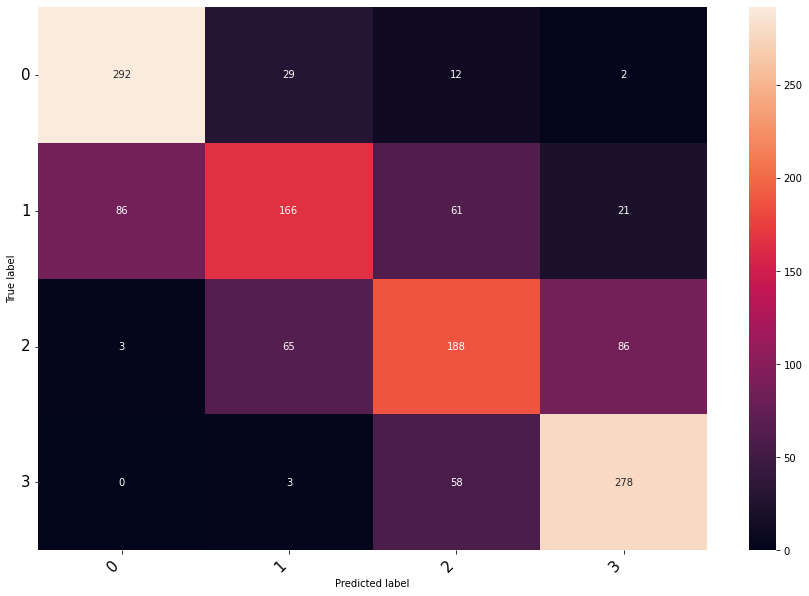

In [95]:
cm.visualize()

In [96]:
cm.class_accuracy

tensor([0.8716, 0.4970, 0.5497, 0.8201])

In [97]:
[mean_squared_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k], squared=False) for k in range(0, cm.size)]

[0.12617399, 0.17978299, 0.13378876, 0.12820777]

In [98]:
[mean_absolute_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k]) for k in range(0, cm.size)]

[0.07974436, 0.13727379, 0.106455795, 0.096512]

#### GraphSAGE Base_n

In [99]:
save_model = f'{save_path}_sage_base'
log_dir = f'{log_path}_sage_base'

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = True,
    target = target,
)

sage_model = dict(
    in_features = [len(dataset.node_attributes)],
    h_features = [[15] * 3, [20], [15], [20] * 2, [15] * 2, [25], [30]], 
    out_features = [out_feats],
    aggregator_type = ['mean', 'lstm'],
    norm_edges = ['right', 'none'],
    norm_nodes = [None, 'bn', 'gn'],
    activation = [torch.nn.ReLU()],
    feat_drop = [0.2, 0],
    # other
    lr=[1e-2],
    use_edge_weight=[True],
    add_self_loop=[True],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(sage_model.keys(), k)) for k in itertools.product(*sage_model.values())]

# sage_model = dict(
#     in_features = [len(dataset.node_attributes)],
#     h_features = [[30] * 3], 
#     out_features = [out_feats],
#     aggregator_type = ['lstm'],
#     norm_edges = ['none'],
#     norm_nodes = ['gn'],
#     activation = [torch.nn.ReLU()],
#     feat_drop = [0],
#     # other
#     lr=[1e-2],
#     label_smoothing=[0.0],
#     use_edge_weight=[True],
#     add_self_loop=[True],
#     drop_edges=[0],
# )
# list_model = [{i:j[k] for i,j in sage_model.items()} for k in range(len(sage_model['in_features']))]

In [100]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        add_self_loop = d.pop('add_self_loop')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        dataset_valid = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=0,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GraphSAGE(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_valid,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=use_edge_weight,
            loss_type='mse',
            base_n=True,
        )

##### Results

In [101]:
res_edges_sage_base = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=True,
    base_n=True,
)

toast.show_toast("Done")

100%|██████████| 2772/2772 [08:32<00:00,  5.41it/s]


True

In [102]:
res_edges = res_edges_sage_base
res_edges[0]

{'in_features': 4,
 'h_features': [20, 20],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'feat_drop': 0,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 0.08956795,
 'train_acc': 0.6190475821495056,
 'val_acc': 0.5111109614372253,
 'epoch': 60,
 'model_class': 'sage',
 'path_name': '4_[20_20]_1_lstm_none_bn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_10_True_0_60',
 'train_rmse': 0.6172133998483676,
 'val_rmse': 0.7453559924999299,
 'test_rmse': 0.7601169500660919,
 'train_rmse_perc': 0.1415397,
 'val_rmse_perc': 0.17430146,
 'test_rmse_perc': 0.17131396,
 'train_mcc': 0.5099400296035141,
 'val_mcc': 0.31479820671610814,
 'test_mcc': 0.38306995002826005,
 'test_acc': 0.5266666412353516,
 'train_mae_perc': 0.1199602,
 'va

In [103]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [15, 15, 15],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'feat_drop': 0,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 0.2956925,
 'train_acc': 0.4285714030265808,
 'val_acc': 0.6222220659255981,
 'epoch': 20,
 'model_class': 'sage',
 'path_name': '4_[15_15_15]_1_lstm_none_bn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_10_True_0_20',
 'train_rmse': 0.7928249671720918,
 'val_rmse': 0.7149203529842405,
 'test_rmse': 0.7712423839590345,
 'train_rmse_perc': 0.18947886,
 'val_rmse_perc': 0.153736,
 'test_rmse_perc': 0.18429664,
 'train_mcc': 0.2996102091580178,
 'val_mcc': 0.47824360246018416,
 'test_mcc': 0.38890172871588824,
 'test_acc': 0.5192592740058899,
 'train_mae_perc': 0.15491956

In [104]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [20, 20],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'feat_drop': 0.2,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 0.37653786,
 'train_acc': 0.39047616720199585,
 'val_acc': 0.48888877034187317,
 'epoch': 30,
 'model_class': 'sage',
 'path_name': '4_[20_20]_1_lstm_none_bn_ReLU()_0.2_0.01_adamw_max_val_mcc_True_mse_10_True_0_30',
 'train_rmse': 0.7988086367179802,
 'val_rmse': 0.7601169500660919,
 'test_rmse': 0.7368602058484113,
 'train_rmse_perc': 0.17712247,
 'val_rmse_perc': 0.16559573,
 'test_rmse_perc': 0.16514902,
 'train_mcc': 0.24488062094484497,
 'val_mcc': 0.26653499941069525,
 'test_mcc': 0.37085597102287693,
 'test_acc': 0.5037037134170532,
 'train_mae_perc': 0.15215

In [105]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 2772/2772 [00:00<00:00, 21216.95it/s]


##### cm

In [106]:
cm = all[sort_idx[0]]['test_cm'][0]

In [107]:
(cm.labels==0).sum()

tensor(335)

<module 'matplotlib.pyplot' from 'c:\\Users\\vibal\\PycharmProjects\\systemic-risk-predictor\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

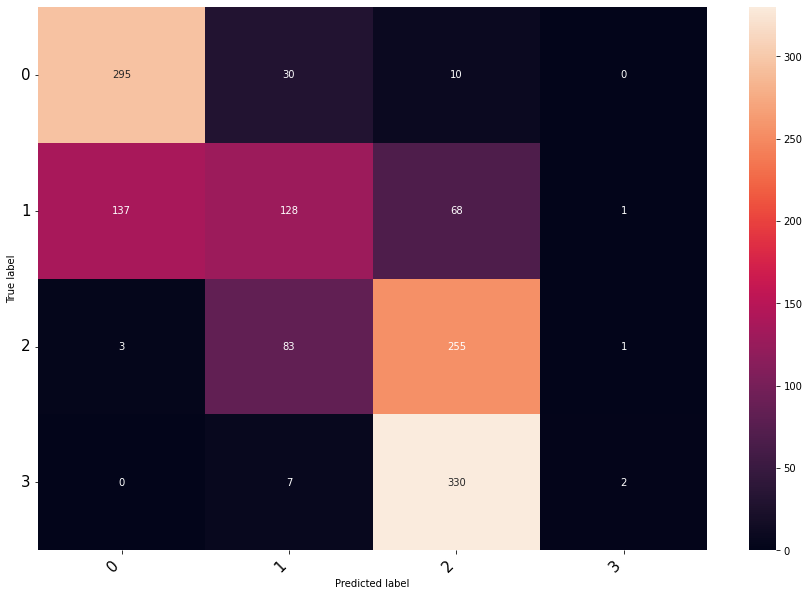

In [108]:
cm.visualize()

In [109]:
cm.class_accuracy

tensor([0.8806, 0.3832, 0.7456, 0.0059])

In [110]:
[mean_squared_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k], squared=False) for k in range(0, cm.size)]

[0.11875651, 0.17232183, 0.118752375, 0.22626002]

In [111]:
[mean_absolute_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k]) for k in range(0, cm.size)]

[0.08503917, 0.14874473, 0.09226213, 0.2083883]

### GAT

In [112]:
save_model = f'{save_path}_gat'
log_dir = f'{log_path}_gat'

add_self_loop = True

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = add_self_loop,
    target = target,
)

gat_model = dict(
    in_features = [len(dataset.node_attributes)],
    h_features = [[10], [10] * 2, [15], [15] * 2, [20], [20] * 2, [25], [25] * 2],
    out_features = [out_feats],
    num_heads = [[4] * 2, [2] * 2, [4, 2]],
    norm_nodes = [None, 'bn', 'gn'],
    activation = [torch.nn.ReLU()],
    negative_slope = [0.2, 0.4],
    feat_drop = [0.2],
    attn_drop = [0.2],
    residual = [True],
    # other
    lr=[1e-2,],
    use_edge_weight=[True, False],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(gat_model.keys(), k)) for k in itertools.product(*gat_model.values())]

# gat_model = dict(
#     in_features = [len(dataset.node_attributes)],
#     # h_features = [[10], [15], [20]], 
#     h_features = [[10] * 3, [15] * 3, [20] * 3], 
#     out_features = [out_feats],
#     # num_heads = [[4] * 4],
#     num_heads = [[4, 2, 2]],
#     norm_nodes = [None, 'bn', 'gn'],
#     activation = [torch.nn.ReLU()],
#     negative_slope = [0.2, 0.3, 0.4],
#     feat_drop = [0.2],
#     attn_drop = [0.2],
#     residual = [True],
#     # other
#     lr=[1e-2,],
#     label_smoothing=[0.0],
#     use_edge_weight=[False],
#     drop_edges=[0,],
# )
# list_model = [dict(zip(gat_model.keys(), k)) for k in itertools.product(*gat_model.values())]
# list_model = [{i:j[k] for i,j in gat_model.items()} for k in range(len(gat_model['in_features']))]

In [113]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        # dataset_valid = ContagionDataset(
        #     raw_dir=data_dir,
        #     drop_edges=0,
        #     sets_lengths=sets_lengths,
        #     add_self_loop = add_self_loop,
        #     target = target,
        #     seed=seed,
        # )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GAT(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_val,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=use_edge_weight,
            loss_type='mse',
        )

#### Results

In [114]:
res_edges_gat = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=False,
)

100%|██████████| 6336/6336 [05:49<00:00, 18.12it/s]


In [115]:
res_edges = res_edges_gat
res_edges[0]

{'in_features': 4,
 'h_features': [20],
 'out_features': 1,
 'num_heads': [2, 2],
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'negative_slope': 0.4,
 'feat_drop': 0.2,
 'attn_drop': 0.2,
 'residual': True,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': False,
 'train_loss_type': 'mse',
 'train_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 0.6039254,
 'train_acc': 0.5619047284126282,
 'val_acc': 0.5111109614372253,
 'epoch': 100,
 'model_class': 'gat',
 'path_name': '4_[20]_1_[2_2]_bn_ReLU()_0.4_0.2_0.2_True_0.01_adamw_max_val_mcc_False_mse_10_True_0_100',
 'train_rmse': 0.7622023228463561,
 'val_rmse': 0.8692269873603532,
 'test_rmse': 0.8432740427115678,
 'train_rmse_perc': 0.16599877,
 'val_rmse_perc': 0.18762124,
 'test_rmse_perc': 0.1965428,
 'train_mcc': 0.4420963579085401,
 'val_mcc': 0.3446739311292904,
 'test_mcc': 0.35541400172094567,
 'test_acc': 0.505185186862

In [116]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [20],
 'out_features': 1,
 'num_heads': [2, 2],
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'negative_slope': 0.4,
 'feat_drop': 0.2,
 'attn_drop': 0.2,
 'residual': True,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': False,
 'train_loss_type': 'mse',
 'train_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 0.73529243,
 'train_acc': 0.5428571105003357,
 'val_acc': 0.4666665494441986,
 'epoch': 90,
 'model_class': 'gat',
 'path_name': '4_[20]_1_[2_2]_bn_ReLU()_0.4_0.2_0.2_True_0.01_adamw_max_val_mcc_False_mse_10_True_0_90',
 'train_rmse': 0.7928249671720918,
 'val_rmse': 0.8944271909999159,
 'test_rmse': 0.8546170899124182,
 'train_rmse_perc': 0.16946457,
 'val_rmse_perc': 0.18739566,
 'test_rmse_perc': 0.19980967,
 'train_mcc': 0.41813126285769453,
 'val_mcc': 0.2859431317947984,
 'test_mcc': 0.3542238675251546,
 'test_acc': 0.503703713417

In [117]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [20],
 'out_features': 1,
 'num_heads': [2, 2],
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'negative_slope': 0.4,
 'feat_drop': 0.2,
 'attn_drop': 0.2,
 'residual': True,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': False,
 'train_loss_type': 'mse',
 'train_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 0.6039254,
 'train_acc': 0.5619047284126282,
 'val_acc': 0.5111109614372253,
 'epoch': 100,
 'model_class': 'gat',
 'path_name': '4_[20]_1_[2_2]_bn_ReLU()_0.4_0.2_0.2_True_0.01_adamw_max_val_mcc_False_mse_10_True_0_100',
 'train_rmse': 0.7622023228463561,
 'val_rmse': 0.8692269873603532,
 'test_rmse': 0.8432740427115678,
 'train_rmse_perc': 0.16599877,
 'val_rmse_perc': 0.18762124,
 'test_rmse_perc': 0.1965428,
 'train_mcc': 0.4420963579085401,
 'val_mcc': 0.3446739311292904,
 'test_mcc': 0.35541400172094567,
 'test_acc': 0.505185186862

In [118]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 6336/6336 [00:00<00:00, 20062.17it/s]
